In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
data = pd.read_excel("PetrolConsumptionGDPReal.xlsx", sheet_name="Sheet1")

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(data.head())

# Display basic information about the dataset
print("\nDataset Info:")
print(data.info())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

First 5 rows of the dataset:
   date  Actual MS 1980-2023       Real GDP
0  1980             542254.0  204617.825536
1  1981             589017.0  217716.910084
2  1982             644907.0  219620.869640
3  1983             690214.0  195215.358025
4  1984             754725.0  190998.787568

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 59 non-null     int64  
 1   Actual MS 1980-2023  44 non-null     float64
 2   Real GDP             59 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.5 KB
None

Missing Values:
date                    0
Actual MS 1980-2023    15
Real GDP                0
dtype: int64


In [3]:
# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'], format='%Y')

# Create temporal features
def create_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    return df

# Apply feature engineering
data = create_features(data)

# Display the updated dataset with new features
print("\nDataset after feature engineering:")
print(data.head())


Dataset after feature engineering:
        date  Actual MS 1980-2023       Real GDP  year  month  day  \
0 1980-01-01             542254.0  204617.825536  1980      1    1   
1 1981-01-01             589017.0  217716.910084  1981      1    1   
2 1982-01-01             644907.0  219620.869640  1982      1    1   
3 1983-01-01             690214.0  195215.358025  1983      1    1   
4 1984-01-01             754725.0  190998.787568  1984      1    1   

   day_of_year  week_of_year  quarter  
0            1             1        1  
1            1             1        1  
2            1            53        1  
3            1            52        1  
4            1            52        1  


In [5]:
# Separate the data into known (1980-2023) and unknown (2024-2038) for forecasting
known_data = data[data['Actual MS 1980-2023'].notna()]
unknown_data = data[data['Actual MS 1980-2023'].isna()]

# Display the known and unknown data
print("Known Data (1980-2023):")
print(known_data.tail())

print("\nUnknown Data (2024-2038):")
print(unknown_data.head())

Known Data (1980-2023):
         date  Actual MS 1980-2023      Real GDP  year  month  day  \
39 2019-01-01            7685985.0  92590.497031  2019      1    1   
40 2020-01-01            7510364.0  79365.962286  2020      1    1   
41 2021-01-01            8515259.0  82876.050091  2021      1    1   
42 2022-01-01            9158934.0  79376.019999  2022      1    1   
43 2023-01-01            7564345.0  56662.989823  2023      1    1   

    day_of_year  week_of_year  quarter  
39            1             1        1  
40            1             1        1  
41            1            53        1  
42            1            52        1  
43            1            52        1  

Unknown Data (2024-2038):
         date  Actual MS 1980-2023      Real GDP  year  month  day  \
44 2024-01-01                  NaN  60186.914062  2024      1    1   
45 2025-01-01                  NaN  63374.964844  2025      1    1   
46 2026-01-01                  NaN  62550.007812  2026      1    1   
47

In [6]:
# Define features and target variable
features = ['year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'Real GDP']
target = 'Actual MS 1980-2023'

# Prepare the training and testing data
X = known_data[features]
y = known_data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (35, 7)
Testing Data Shape: (9, 7)


In [7]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    colsample_bytree=0.5,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Display the first few predictions
print("First 5 Predictions:")
print(y_pred[:5])

First 5 Predictions:
[4900726.    990532.56 1138872.2  4917053.   3274510.  ]


In [8]:
# Evaluate the model using metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Model Evaluation Metrics:
Mean Squared Error (MSE): 527386506542.78906
Mean Absolute Error (MAE): 465939.77777777775
Mean Absolute Percentage Error (MAPE): 0.11609869925268021
Root Mean Squared Error (RMSE): 726213.8159955296


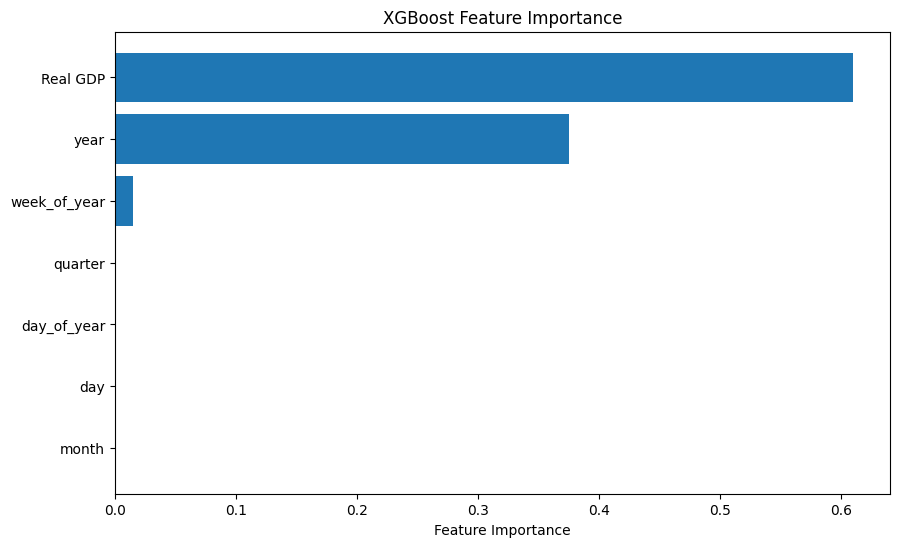

In [9]:
# Plot feature importance
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

In [10]:
# Prepare the unknown data for forecasting
X_unknown = unknown_data[features]

# Predict Crude Oil consumption for 2024-2038
forecasted_values = model.predict(X_unknown)

# Add forecasted values to the unknown data
unknown_data['Actual MS 1980-2023'] = forecasted_values

# Display the forecasted values
print("Forecasted Crude Oil Consumption (2024-2038):")
print(unknown_data[['date', 'Actual MS 1980-2023']])

Forecasted Crude Oil Consumption (2024-2038):
         date  Actual MS 1980-2023
44 2024-01-01            7419694.0
45 2025-01-01            7419694.0
46 2026-01-01            7419694.0
47 2027-01-01            7554157.5
48 2028-01-01            7573931.0
49 2029-01-01            7419694.0
50 2030-01-01            7419694.0
51 2031-01-01            7419694.0
52 2032-01-01            7419694.0
53 2033-01-01            7554157.5
54 2034-01-01            7573931.0
55 2035-01-01            7419694.0
56 2036-01-01            7419694.0
57 2037-01-01            7419694.0
58 2038-01-01            7554157.5


C:\Users\MoaviaHassan\AppData\Local\Temp\ipykernel_11424\1892326997.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Actual MS 1980-2023'] = forecasted_values


In [11]:
# Combine known and forecasted data
final_data = pd.concat([known_data, unknown_data]).sort_values(by='date')

# Save the final dataset with forecasted values
final_data.to_excel("Forecasted_Petrol_Consumption.xlsx", index=False)

# Display the final dataset
print("Final Dataset with Forecasted Values:")
print(final_data.tail(20))

Final Dataset with Forecasted Values:
         date  Actual MS 1980-2023      Real GDP  year  month  day  \
39 2019-01-01            7685985.0  92590.497031  2019      1    1   
40 2020-01-01            7510364.0  79365.962286  2020      1    1   
41 2021-01-01            8515259.0  82876.050091  2021      1    1   
42 2022-01-01            9158934.0  79376.019999  2022      1    1   
43 2023-01-01            7564345.0  56662.989823  2023      1    1   
44 2024-01-01            7419694.0  60186.914062  2024      1    1   
45 2025-01-01            7419694.0  63374.964844  2025      1    1   
46 2026-01-01            7419694.0  62550.007812  2026      1    1   
47 2027-01-01            7554157.5  65516.738281  2027      1    1   
48 2028-01-01            7573931.0  64598.535156  2028      1    1   
49 2029-01-01            7419694.0  63254.734375  2029      1    1   
50 2030-01-01            7419694.0  63719.175781  2030      1    1   
51 2031-01-01            7419694.0  64197.585938  20

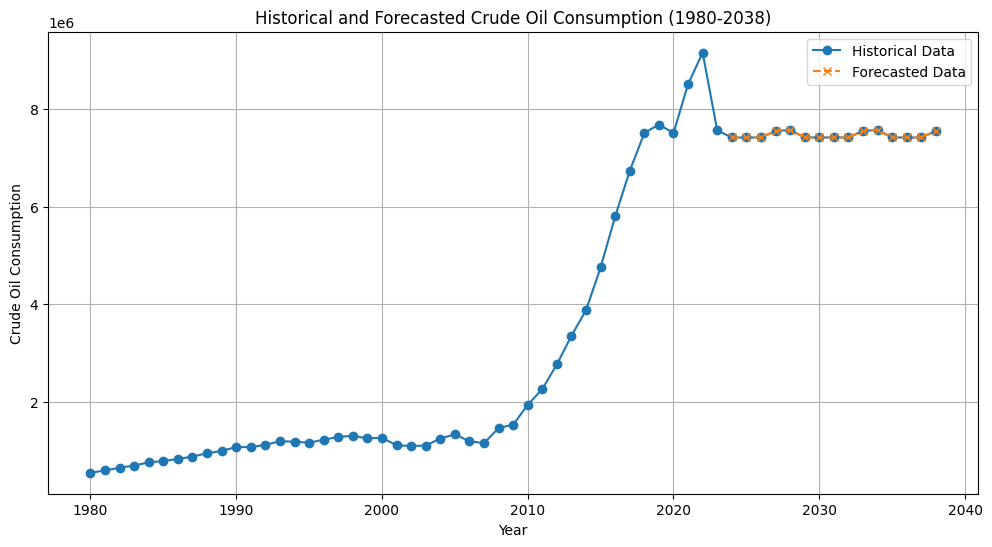

In [12]:
# Plot the historical and forecasted Crude Oil consumption
plt.figure(figsize=(12, 6))
plt.plot(final_data['date'], final_data['Actual MS 1980-2023'], label='Historical Data', marker='o')
plt.plot(unknown_data['date'], unknown_data['Actual MS 1980-2023'], label='Forecasted Data', marker='x', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Crude Oil Consumption')
plt.title('Historical and Forecasted Crude Oil Consumption (1980-2038)')
plt.legend()
plt.grid()
plt.show()
